In [22]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch as Patch
import numpy as np
import pandas as pd
import time
import os
import seaborn as sns
from scipy import stats
import sklearn.preprocessing as skp
import sklearn.cluster as skc
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture
from sklearn.model_selection import train_test_split
from scipy import linalg
import itertools

In [87]:
from matplotlib.patches import Ellipse
color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange","green","pink"])




def draw_ellipse(mean, covariance, alpha,color,ax=None):
    ax = plt.gca()
    v, w = linalg.eigh(covariance)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        #if not np.any(Y_ == i):
         #   continue
        #plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    ell = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    #ell.set_clip_box(splot.bbox)
    ell.set_alpha(alpha)
    #ax.add_patch(ell)
    ax.add_artist(ell)
        


In [2]:
outdir = './data/processed_data'

In [3]:
 # read data from the file and plot 
filename = os.path.join(outdir, f"cleanded_diabetes_data.csv" )    
diabetes_df = pd.read_csv(filename)

In [4]:
# drop Diabetes_012 column from dataset to get input matrix X
X = diabetes_df.drop('Diabetes_012', axis=1)
# Extract Diabetes_012 column to generate output vector y
y = diabetes_df['Diabetes_012']

In [5]:
X_train, X_test, y_train_true, y_test_true = train_test_split(X, y, test_size=0.2)

## Decide on the cluster count using Elbow method 

In [12]:
###Decide n-cluster using Elbow Method
bic=[]
aic =[]
k_range = range(2,10)
for i in k_range:
    gmm_temp = GaussianMixture(n_components=i, n_init=10)
    gmm_temp.fit(X_train)
    bic.append(gmm_temp.bic(X_train))
    aic.append(gmm_temp.aic(X_train))

# save the data for future use
bic_filename = os.path.join(outdir, f"bic_scores2_10.npy" )    
np.save(bic_filename, bic)

aic_filename = os.path.join(outdir, f"aic_scores2_10.npy" )    
np.save(aic_filename, aic)

In [7]:
print(len(bic))

8


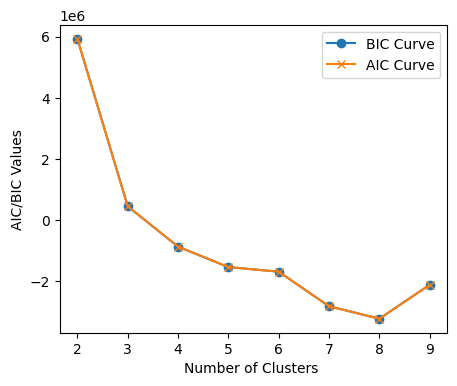

In [15]:
bic_filename = os.path.join(outdir, f"bic_scores2_10.npy" )    
aic_filename = os.path.join(outdir, f"bic_scores2_10.npy" )    
x_range = np.arange(2,10)
bic=np.load(bic_filename)
aic =np.load(aic_filename)


fig1 = plt.figure(figsize = (5,4))
plt.plot(x_range, bic, marker='o', label = "BIC Curve")
plt.plot(x_range, aic, marker='x', label = "AIC Curve")
plt.xlabel("Number of Clusters ")
plt.ylabel("AIC/BIC Values")
# for i, value in enumerate(wcss):
#     ax.text(i+1.05, value-0.005, round(value,1), fontsize=12, fontweight='bold')
    
#fig1.suptitle("Elbow Method");
plt.legend()
plt.show()

In [16]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10)
bgm.fit(X_train)
np.round(bgm.weights_, 2)

array([0.15, 0.02, 0.  , 0.17, 0.54, 0.  , 0.07, 0.02, 0.  , 0.01])

In [17]:
gmm = GaussianMixture(n_components=7, n_init=10)

In [33]:
gmm.fit(X_train)

GaussianMixture(n_components=7, n_init=10)

In [34]:
predictions = gmm.predict_proba(X_train)

In [35]:
labels = gmm.predict(X_train)

In [67]:
X_train['pred_prob'] = predictions
X_train['labels'] = labels

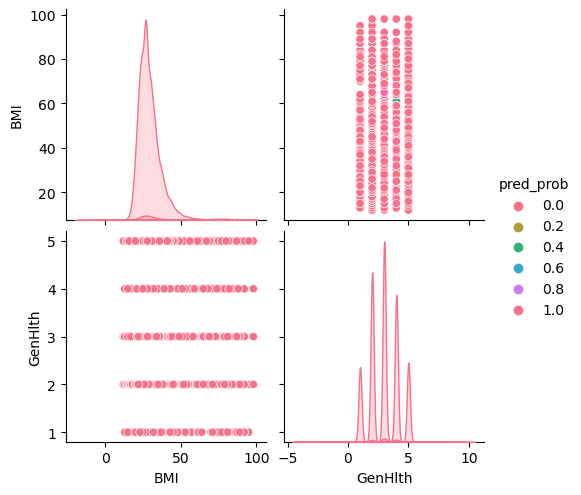

In [93]:
sns.pairplot(X_train, vars=["BMI","GenHlth"], hue="pred_prob" , kind = "scatter",palette = "husl")

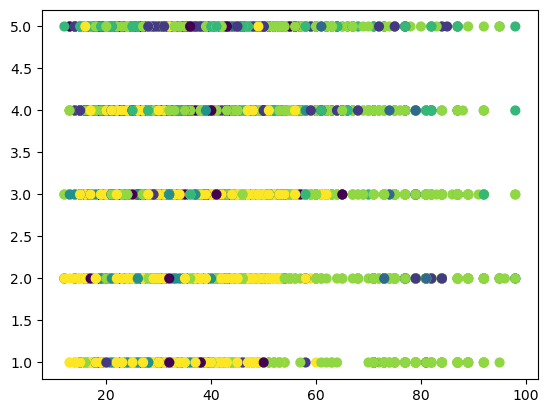

In [94]:
size = 50 * predictions.max(1) ** 2  # square emphasizes differences
#plt.scatter(X_train["BMI"], X_train["GenHlth"], c=labels, cmap='viridis', s=size);
ax = plt.gca()
ax.scatter(X_train["BMI"], X_train["GenHlth"], c=labels, s=40, cmap='viridis', zorder=2)
w_factor = 0.2 / gmm.weights_.max()
for mean, covar, w, color in zip(gmm.means_, gmm.covariances_, gmm.weights_, color_iter):
    alpha =w * w_factor 
    draw_ellipse(mean, covar, w, color,ax)

In [66]:
gmm.converged_

True

In [159]:
X_train.columns

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

<Axes: xlabel='labels', ylabel='BMI'>

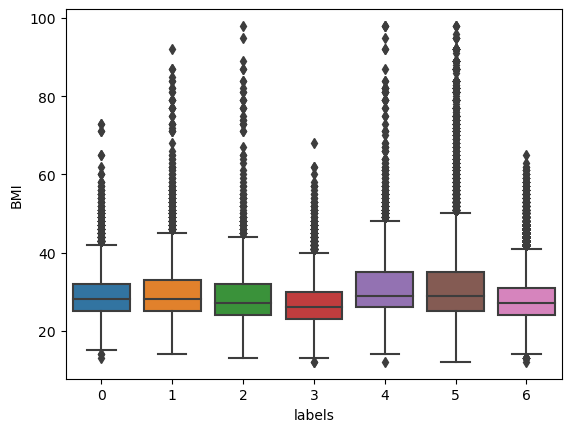

In [68]:
sns.boxplot(X_train, y='BMI',x='labels')

## K Means 